In [1]:
# use 127.0.0.1:23010
from feat.utils import get_resource_path
class ResMaskNet:
    def __init__(self):
        """Initialize ResMaskNet

        @misc{luanresmaskingnet2020,
        Author = {Luan Pham & Tuan Anh Tran},
        Title = {Facial Expression Recognition using Residual Masking Network},
        url = {https://github.com/phamquiluan/ResidualMaskingNetwork},
        Year = {2020}
        }

        """
        self.transform = transforms.Compose(
            [transforms.ToPILImage(), transforms.ToTensor()]
        )

        self.FER_2013_EMO_DICT = {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

        # load configs and set random seed
        configs = json.load(
            open(os.path.join(get_resource_path(), "ResMaskNet_fer2013_config.json"))
        )
        self.image_size = (configs["image_size"], configs["image_size"])
        self.use_gpu = torch.cuda.is_available()
        # if self.use_gpu:
        #     self.state = torch.load(
        #         os.path.join(
        #             get_resource_path(), "ResMaskNet_Z_resmasking_dropout1_rot30.pth"
        #         )
        #     )
        # else:
        #     self.state = torch.load(
        #         os.path.join(
        #             get_resource_path(), "ResMaskNet_Z_resmasking_dropout1_rot30.pth"
        #         ),
        #         map_location={"cuda:0": "cpu"},
        #     )

        self.model = resmasking_dropout1(in_channels=3, num_classes=7)
        
        if self.use_gpu:
            self.model.load_state_dict(
                torch.load(
                    os.path.join(
                        get_resource_path(), "ResMaskNet_Z_resmasking_dropout1_rot30.pth"
                        )
                    )['net']
                )
            self.model.cuda()

        else:
            self.model.load_state_dict(
                torch.load(
                    os.path.join(
                        get_resource_path(), "ResMaskNet_Z_resmasking_dropout1_rot30.pth"
                    ),
                map_location={"cuda:0": "cpu"},
                )['net']
            )
        self.model.eval()


    def detect_emo(self, frame, detected_face, *args, **kwargs):
        """Detect emotions.

        Args:
            frame ([type]): [description]

        Returns:
            List of predicted emotions in probability: [angry, disgust, fear, happy, sad, surprise, neutral]
        """


        with torch.no_grad():
            frame = np.fliplr(frame).astype(np.uint8)
            h, w = frame.shape[:2]
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            start_x, start_y, end_x, end_y, conf = np.array(detected_face[0]).astype(
                int
            )
            # covnert to square images
            center_x, center_y = (start_x + end_x) // 2, (start_y + end_y) // 2
            square_length = ((end_x - start_x) + (end_y - start_y)) // 2 // 2
            square_length *= 1.1
            start_x = int(center_x - square_length)
            start_y = int(center_y - square_length)
            end_x = int(center_x + square_length)
            end_y = int(center_y + square_length)
            if start_x < 0:
                start_x = 0
            if start_y < 0:
                start_y = 0
            face = gray[start_y:end_y, start_x:end_x]
            face = ensure_color(face)
            face = cv2.resize(face, self.image_size)
            if self.use_gpu:
                face = self.transform(face).cuda()
            else:
                face = self.transform(face)
            face = torch.unsqueeze(face, dim=0)
            output = torch.squeeze(self.model(face), 0)
            proba = torch.softmax(output, 0)
            proba_np = proba.cpu().numpy()
            return [proba_np]

/opt/conda/envs/pybert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
# from torch.nn.parallel import DistributedDataParallel
from resmasknet_test import *
import random
from tqdm import tqdm
from PIL import Image
import cv2
import numpy as np
# from tensorboardX import SummaryWriter
import json
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from human_data import feat_order, base_folders

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(1)

# print(random.sample(range(50), 10))

# Type 2 split a small set of figure as valid set first.
CURR_EMO = 'happy'
aver_sorted_data = average_human_order[CURR_EMO]
g_data, b_data = feat_order[CURR_EMO][:50], feat_order[CURR_EMO][50:]
base_folder = base_folders[CURR_EMO]

aver_sorted_g_data = [i for i in aver_sorted_data if i in g_data]
aver_sorted_b_data = [i for i in aver_sorted_data if i in b_data]

def generate_dataset_with_neg(good_set, bad_set, base_folder):
    dataset = []
    for i in range(len(good_set)):
        for j in range(i+1, len(good_set)):
            dataset.append([[good_set[i], good_set[j]], 1])

    for i in good_set:
        for j in bad_set:
            dataset.append([[i, j], 1])
    for i in range(len(dataset)):
        dataset[i][0] = [os.path.join(base_folder, dataset[i][0][j]) for j in range(len(dataset[i][0]))]
    return dataset

def valid_image_split_func(humandata):
    valid_set_index = random.sample(range(50), 10)
    valid_set_index.sort()
    train_set_index = [i for i in range(50) if i not in valid_set_index]
    train_set_index.sort()

    train_set_name = [humandata[i] for i in train_set_index]
    valid_set_name = [humandata[i] for i in valid_set_index]
    
    return train_set_name, valid_set_name



train_set_g_name, valid_set_g_name = valid_image_split_func(aver_sorted_g_data)
train_set_b_name, valid_set_b_name = valid_image_split_func(aver_sorted_g_data)

train_set = generate_dataset_with_neg(train_set_g_name, train_set_b_name, base_folder)
valid_set = generate_dataset_with_neg(valid_set_g_name, valid_set_b_name, base_folder)

print(len(train_set))
print(len(valid_set))
print(len(valid_set)/len(train_set))

2380
145
0.06092436974789916


In [113]:

class PairwiseRatingDataset(Dataset):
    def __init__(self, data, transform=None, mode='train'):
        
        self.data = data
        self.transform = transform

        # compute pairs and labels
        self.pairs = [i[0] for i in self.data]
        self.labels = [i[1] for i in self.data]

        # self.pairs = self.load_image_data()
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1 = Image.open(self.pairs[idx][0])
        img2 = Image.open(self.pairs[idx][1])
        
        # pre computed face box
        start_x, start_y, end_x, end_y = 193, 114, 442, 363
    
        img1 = img1.crop([start_x, start_y, end_x, end_y])
        img2 = img2.crop([start_x, start_y, end_x, end_y])

        # Apply transformations if any
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, self.labels[idx]


    # def __getitem__(self, idx):
    #     return self.pairs[idx][0], self.pairs[idx][1], self.labels[idx]

    # def load_image_data(self):
    #     print('loading image data...')
    #     # Load images and label for a given index
    #     image_pairs = []
        
    #     for i in range(self.__len__()):
    #         img1 = Image.open(self.pairs[i][0])
    #         img2 = Image.open(self.pairs[i][1])

    #         # Apply transformations if any
    #         if self.transform:
    #             img1 = self.transform(img1)
    #             img2 = self.transform(img2)
            
    #         image_pairs.append([img1, img2])

    #     return image_pairs
        

# Define transformations to be applied to images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = PairwiseRatingDataset(train_set, transform=transform)
val_dataset = PairwiseRatingDataset(valid_set, transform=transform)

In [115]:
for i,v in enumerate(train_dataset):
    print(i)
    print(v)

0
(tensor([[[ 0.2941,  0.3255,  0.3647,  ..., -0.3255, -0.3098, -0.3412],
         [ 0.3176,  0.3490,  0.3490,  ..., -0.3098, -0.3176, -0.3412],
         [ 0.3333,  0.3490,  0.3333,  ..., -0.3412, -0.3333, -0.3490],
         ...,
         [-0.5451, -0.4745, -0.4353,  ...,  0.1686,  0.1686,  0.1529],
         [-0.5608, -0.4510, -0.4275,  ...,  0.1608,  0.1686,  0.1686],
         [-0.4902, -0.4275, -0.4039,  ...,  0.1451,  0.1608,  0.1608]],

        [[ 0.3490,  0.3647,  0.3961,  ..., -0.1373, -0.1686, -0.2157],
         [ 0.3647,  0.3961,  0.3961,  ..., -0.1451, -0.1922, -0.2392],
         [ 0.3882,  0.3961,  0.3725,  ..., -0.2000, -0.2078, -0.2392],
         ...,
         [-0.4196, -0.3412, -0.3020,  ...,  0.2000,  0.2157,  0.2000],
         [-0.4039, -0.3020, -0.2784,  ...,  0.1922,  0.2157,  0.2157],
         [-0.3255, -0.2941, -0.2627,  ...,  0.1922,  0.2078,  0.2078]],

        [[ 0.3647,  0.3882,  0.4196,  ..., -0.4902, -0.5137, -0.5529],
         [ 0.3882,  0.4353,  0.4275,  ...,

KeyboardInterrupt: 

In [ ]:
def split_data(data):
    # Split data into train, val sets
    num_data = len(raw_data)
    num_train = int(0.8 * num_data)
    num_val = num_data - num_train

    # Create indices for train and val sets
    indices = list(range(num_data))
    random.shuffle(indices)
    train_indices = indices[:num_train]
    val_indices = indices[num_train:]

    # Create train and val datasets by indexing the PairwiseRatingDataset instance
    train_dataset = [raw_data[i] for i in train_indices]
    val_dataset = [raw_data[i] for i in val_indices]
    train_dataset = PairwiseRatingDataset(train_dataset, transform=transform)
    val_dataset = PairwiseRatingDataset(val_dataset, transform=transform)

    return train_dataset, val_dataset





In [3]:
class SiameseRankNet(nn.Module):
    def __init__(self, model_path):
        super(SiameseRankNet, self).__init__()
        # Load ResMaskNet model
        # self.model = resmasking_dropout1(in_channels=3, num_classes=7)
        self.model = ResMasking('')
        # freeze
        # for param in self.model.parameters():
        #     param.requires_grad = False
        # unfreeze
        # Define the fully connected layers on top of concatenated feature vectors
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )
        
        self.use_gpu = torch.cuda.is_available()
        self.image_size = 224

        self.FER_2013_EMO_DICT = {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }
        self.FER_2013_EMONUM = {v:k for k, v in self.FER_2013_EMO_DICT.items()}
        self.emotion = 'happy'
        self.idx = self.FER_2013_EMONUM[self.emotion]
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        self.sigmoid = nn.Sigmoid()
        # self.activation = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.5)
        # self.relu = nn.ReLU()
        self.model_path = model_path
        
        
        
        
        if self.use_gpu:
            self.state_dict = torch.load(self.model_path)
            for key in list(self.state_dict.keys()):
                self.state_dict[key.replace("module.model.","")] = self.state_dict.pop(key)
            self.model.load_state_dict(self.state_dict)
            self.model.cuda()

        else:
            self.state_dict = torch.load(self.model_path, map_location={"cuda:0": "cpu"},)
            for key in list(self.state_dict.keys()):
                self.state_dict[key.replace("module.model.","")] = self.state_dict.pop(key)
            self.model.load_state_dict()
        self.model.eval()
        
    def detect_emo(self, frame, detected_face="", *args, **kwargs):
        """Detect emotions.

        Args:
            frame ([type]): [description]

        Returns:
            List of predicted emotions in probability: [angry, disgust, fear, happy, sad, surprise, neutral]
        """

        with torch.no_grad():
            # frame = np.fliplr(frame).astype(np.uint8)
            # h, w = frame.shape[:2]
            # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # start_x, start_y, end_x, end_y, conf = np.array(detected_face[0]).astype(
            #     int
            # )

            # test
            start_x, start_y, end_x, end_y = 193, 114, 442, 363

            # # covnert to square images
            # center_x, center_y = (start_x + end_x) // 2, (start_y + end_y) // 2
            # square_length = ((end_x - start_x) + (end_y - start_y)) // 2 // 2
            # square_length *= 1.1
            # start_x = int(center_x - square_length)
            # start_y = int(center_y - square_length)
            # end_x = int(center_x + square_length)
            # end_y = int(center_y + square_length)
            # if start_x < 0:
            #     start_x = 0
            # if start_y < 0:
            #     start_y = 0
            # face = gray[start_y:end_y, start_x:end_x]
            # face = ensure_color(face)
            # face = cv2.resize(face, (self.image_size, self.image_size))
    
            face = frame.crop([start_x, start_y, end_x, end_y])


            
            
            if self.use_gpu:
                face = self.transform(face).cuda()
            else:
                face = self.transform(face)
            face = torch.unsqueeze(face, dim=0)
            output = torch.squeeze(self.model(face), 0)
            # proba = torch.softmax(output, 0)
            # proba_np = proba.cpu().numpy()
            return output



path1 = "check_points/Happy_Rank1_50_v1/20230809_170453/model_20230809_170453_epoch2.pt"
model = SiameseRankNet(path1)
# model2 = ResMaskNet()

# print(model.detect_emo(Image.open('data/happiness_selected_imgonly100/ha_1.png')))


In [4]:
model.model.fc

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=7, bias=True)
)

In [37]:
aver_4_sorted_data == average_human_order[myexp]

True

In [42]:
myexp = 'happy'
exp_aver_human = average_human_order[myexp]

# debug for pyfeat ranking
# cleaned_data = feat_order['happy'][:5]
cleaned_data = feat_order[myexp]

final_res = []
for i in exp_aver_human:
    tmp_path = os.path.join('data/happiness_selected_imgonly100', i)
    tmp_res = {}
    for k,v in model.FER_2013_EMO_DICT.items():
        # print(k)
        # print(model.detect_emo(Image.open(tmp_path)))
        tmp_res[v] = list(model.detect_emo(Image.open(tmp_path)))[k]
    # print(tmp_res['happy'])
    final_res.append(tmp_res['happy'].tolist())
    # print(tmp_res)
    # print()
print('Inference finished.')


Inference finished.


In [44]:
bak_final_res = copy.deepcopy(final_res)

In [45]:
# rescaling 
max_final_res = max(final_res)
min_final_res = min(final_res)
for i,v in enumerate(final_res):
    final_res[i] = (v - min_final_res) / (max_final_res - min_final_res)
print(final_res) # in exp_aver_human order


[0.4626103659449325, 0.6273322329844783, 0.7287114599623128, 0.8627170767475381, 0.6340837808236262, 0.7522353753782199, 0.7666949307548021, 0.513779144694467, 0.4425944840069739, 0.7911838799854528, 0.5133445273056755, 0.7061518570093542, 0.7809462324546423, 0.41190135219798474, 0.6613162537871848, 0.7545471143476778, 0.5587757559831322, 0.7061614398453947, 0.8197740543201125, 0.5091503416544958, 0.6794954333035902, 0.6818690795051429, 0.5555267640400101, 0.5813539967897852, 0.5826427181624113, 0.7849677745762269, 0.3745277286339762, 0.6272666779408674, 0.7460905137218823, 0.5388644524614975, 0.6196036463946168, 0.7225753776851382, 0.8271575532488407, 0.7464972271119709, 0.5390156900231933, 0.3783075651224085, 0.5081363908046155, 0.6174025968054695, 0.5229117164632818, 0.8296345228318869, 0.4585794051974722, 0.590766628994509, 0.8370961447464746, 0.7782794124625991, 0.7729897221561667, 0.7335951347718566, 0.5405702441938863, 0.4740218229209662, 0.6761412178327829, 0.23637124249316163,

In [46]:
print(len(final_res))
print(final_res)

100
[0.4626103659449325, 0.6273322329844783, 0.7287114599623128, 0.8627170767475381, 0.6340837808236262, 0.7522353753782199, 0.7666949307548021, 0.513779144694467, 0.4425944840069739, 0.7911838799854528, 0.5133445273056755, 0.7061518570093542, 0.7809462324546423, 0.41190135219798474, 0.6613162537871848, 0.7545471143476778, 0.5587757559831322, 0.7061614398453947, 0.8197740543201125, 0.5091503416544958, 0.6794954333035902, 0.6818690795051429, 0.5555267640400101, 0.5813539967897852, 0.5826427181624113, 0.7849677745762269, 0.3745277286339762, 0.6272666779408674, 0.7460905137218823, 0.5388644524614975, 0.6196036463946168, 0.7225753776851382, 0.8271575532488407, 0.7464972271119709, 0.5390156900231933, 0.3783075651224085, 0.5081363908046155, 0.6174025968054695, 0.5229117164632818, 0.8296345228318869, 0.4585794051974722, 0.590766628994509, 0.8370961447464746, 0.7782794124625991, 0.7729897221561667, 0.7335951347718566, 0.5405702441938863, 0.4740218229209662, 0.6761412178327829, 0.23637124249316

In [62]:
# final_res is in prediction result in exp_aver_human order

final_rank = [[i, v] for i, v in enumerate(final_res)]
# print(final_rank) # average human rating order

In [63]:
final_rank.sort(key=lambda x:x[1], reverse=True)
final_rank = [[i, v] for i, v in enumerate(final_rank)]
final_rank.sort(key=lambda x:x[1][0], reverse=False)
print(final_rank)
# [new RMN ranking, [average human ranking, new RMN score]] (in average human rating order)

[[53, [0, 0.4626103659449325]], [29, [1, 0.6273322329844783]], [18, [2, 0.7287114599623128]], [1, [3, 0.8627170767475381]], [27, [4, 0.6340837808236262]], [14, [5, 0.7522353753782199]], [12, [6, 0.7666949307548021]], [48, [7, 0.513779144694467]], [56, [8, 0.4425944840069739]], [6, [9, 0.7911838799854528]], [49, [10, 0.5133445273056755]], [21, [11, 0.7061518570093542]], [9, [12, 0.7809462324546423]], [58, [13, 0.41190135219798474]], [26, [14, 0.6613162537871848]], [13, [15, 0.7545471143476778]], [38, [16, 0.5587757559831322]], [20, [17, 0.7061614398453947]], [5, [18, 0.8197740543201125]], [50, [19, 0.5091503416544958]], [24, [20, 0.6794954333035902]], [23, [21, 0.6818690795051429]], [39, [22, 0.5555267640400101]], [35, [23, 0.5813539967897852]], [34, [24, 0.5826427181624113]], [7, [25, 0.7849677745762269]], [63, [26, 0.3745277286339762]], [30, [27, 0.6272666779408674]], [16, [28, 0.7460905137218823]], [43, [29, 0.5388644524614975]], [31, [30, 0.6196036463946168]], [19, [31, 0.7225753776

In [55]:
# # test for pyfeat ranking
# cleaned_data = feat_order['happy'][-5:]

# for i in cleaned_data:
#     tmp_path = os.path.join('data/happiness_selected_imgonly100', i)
#     tmp_res = {}
#     for k,v in model.FER_2013_EMO_DICT.items():
#         # print(k)
#         # print(model.detect_emo(Image.open(tmp_path)))
#         tmp_res[v] = list(model.detect_emo(Image.open(tmp_path)))[k]
#     print(tmp_res['happy'])
#     print()
    

# Regression plot

In [33]:
print(average_human_order[myexp])
# print(final_rank)
print(feat_order[myexp])

['ha_428.png', 'ha_393.png', 'ha_407.png', 'ha_422.png', 'ha_341.png', 'ha_202.png', 'ha_235.png', 'ha_288.png', 'ha_50.png', 'ha_489.png', 'ha_212.png', 'ha_450.png', 'ha_348.png', 'ha_24.png', 'ha_443.png', 'ha_256.png', 'ha_412.png', 'ha_185.png', 'ha_301.png', 'ha_11.png', 'ha_201.png', 'ha_497.png', 'ha_384.png', 'ha_27.png', 'ha_184.png', 'ha_368.png', 'ha_268.png', 'ha_442.png', 'ha_491.png', 'ha_367.png', 'ha_311.png', 'ha_19.png', 'ha_243.png', 'ha_249.png', 'ha_215.png', 'ha_107.png', 'ha_130.png', 'ha_221.png', 'ha_303.png', 'ha_342.png', 'ha_244.png', 'ha_2.png', 'ha_54.png', 'ha_320.png', 'ha_32.png', 'ha_329.png', 'ha_241.png', 'ha_315.png', 'ha_33.png', 'ha_451.png', 'ha_151.png', 'ha_5.png', 'ha_476.png', 'ha_296.png', 'ha_344.png', 'ha_1.png', 'ha_152.png', 'ha_132.png', 'ha_172.png', 'ha_207.png', 'ha_377.png', 'ha_131.png', 'ha_404.png', 'ha_149.png', 'ha_477.png', 'ha_466.png', 'ha_454.png', 'ha_186.png', 'ha_122.png', 'ha_106.png', 'ha_124.png', 'ha_43.png', 'ha_29

In [68]:
tmp_dic = {v:idx for idx,v in enumerate(feat_order[myexp])}
# feat order when average_human_order is the reference, x axis
old_feat_order = [tmp_dic[k] for k in average_human_order[myexp]]
print(old_feat_order)

[33, 39, 21, 27, 14, 25, 31, 32, 40, 34, 26, 13, 1, 36, 17, 15, 18, 9, 10, 35, 6, 3, 30, 29, 2, 5, 69, 28, 7, 41, 12, 50, 20, 11, 46, 48, 52, 16, 42, 4, 58, 44, 45, 43, 8, 23, 37, 68, 19, 83, 51, 49, 24, 65, 22, 59, 0, 47, 38, 91, 71, 79, 74, 77, 72, 60, 53, 61, 70, 64, 99, 62, 63, 90, 92, 82, 85, 56, 76, 89, 98, 86, 57, 87, 54, 55, 80, 84, 67, 94, 96, 73, 66, 78, 81, 95, 88, 93, 75, 97]


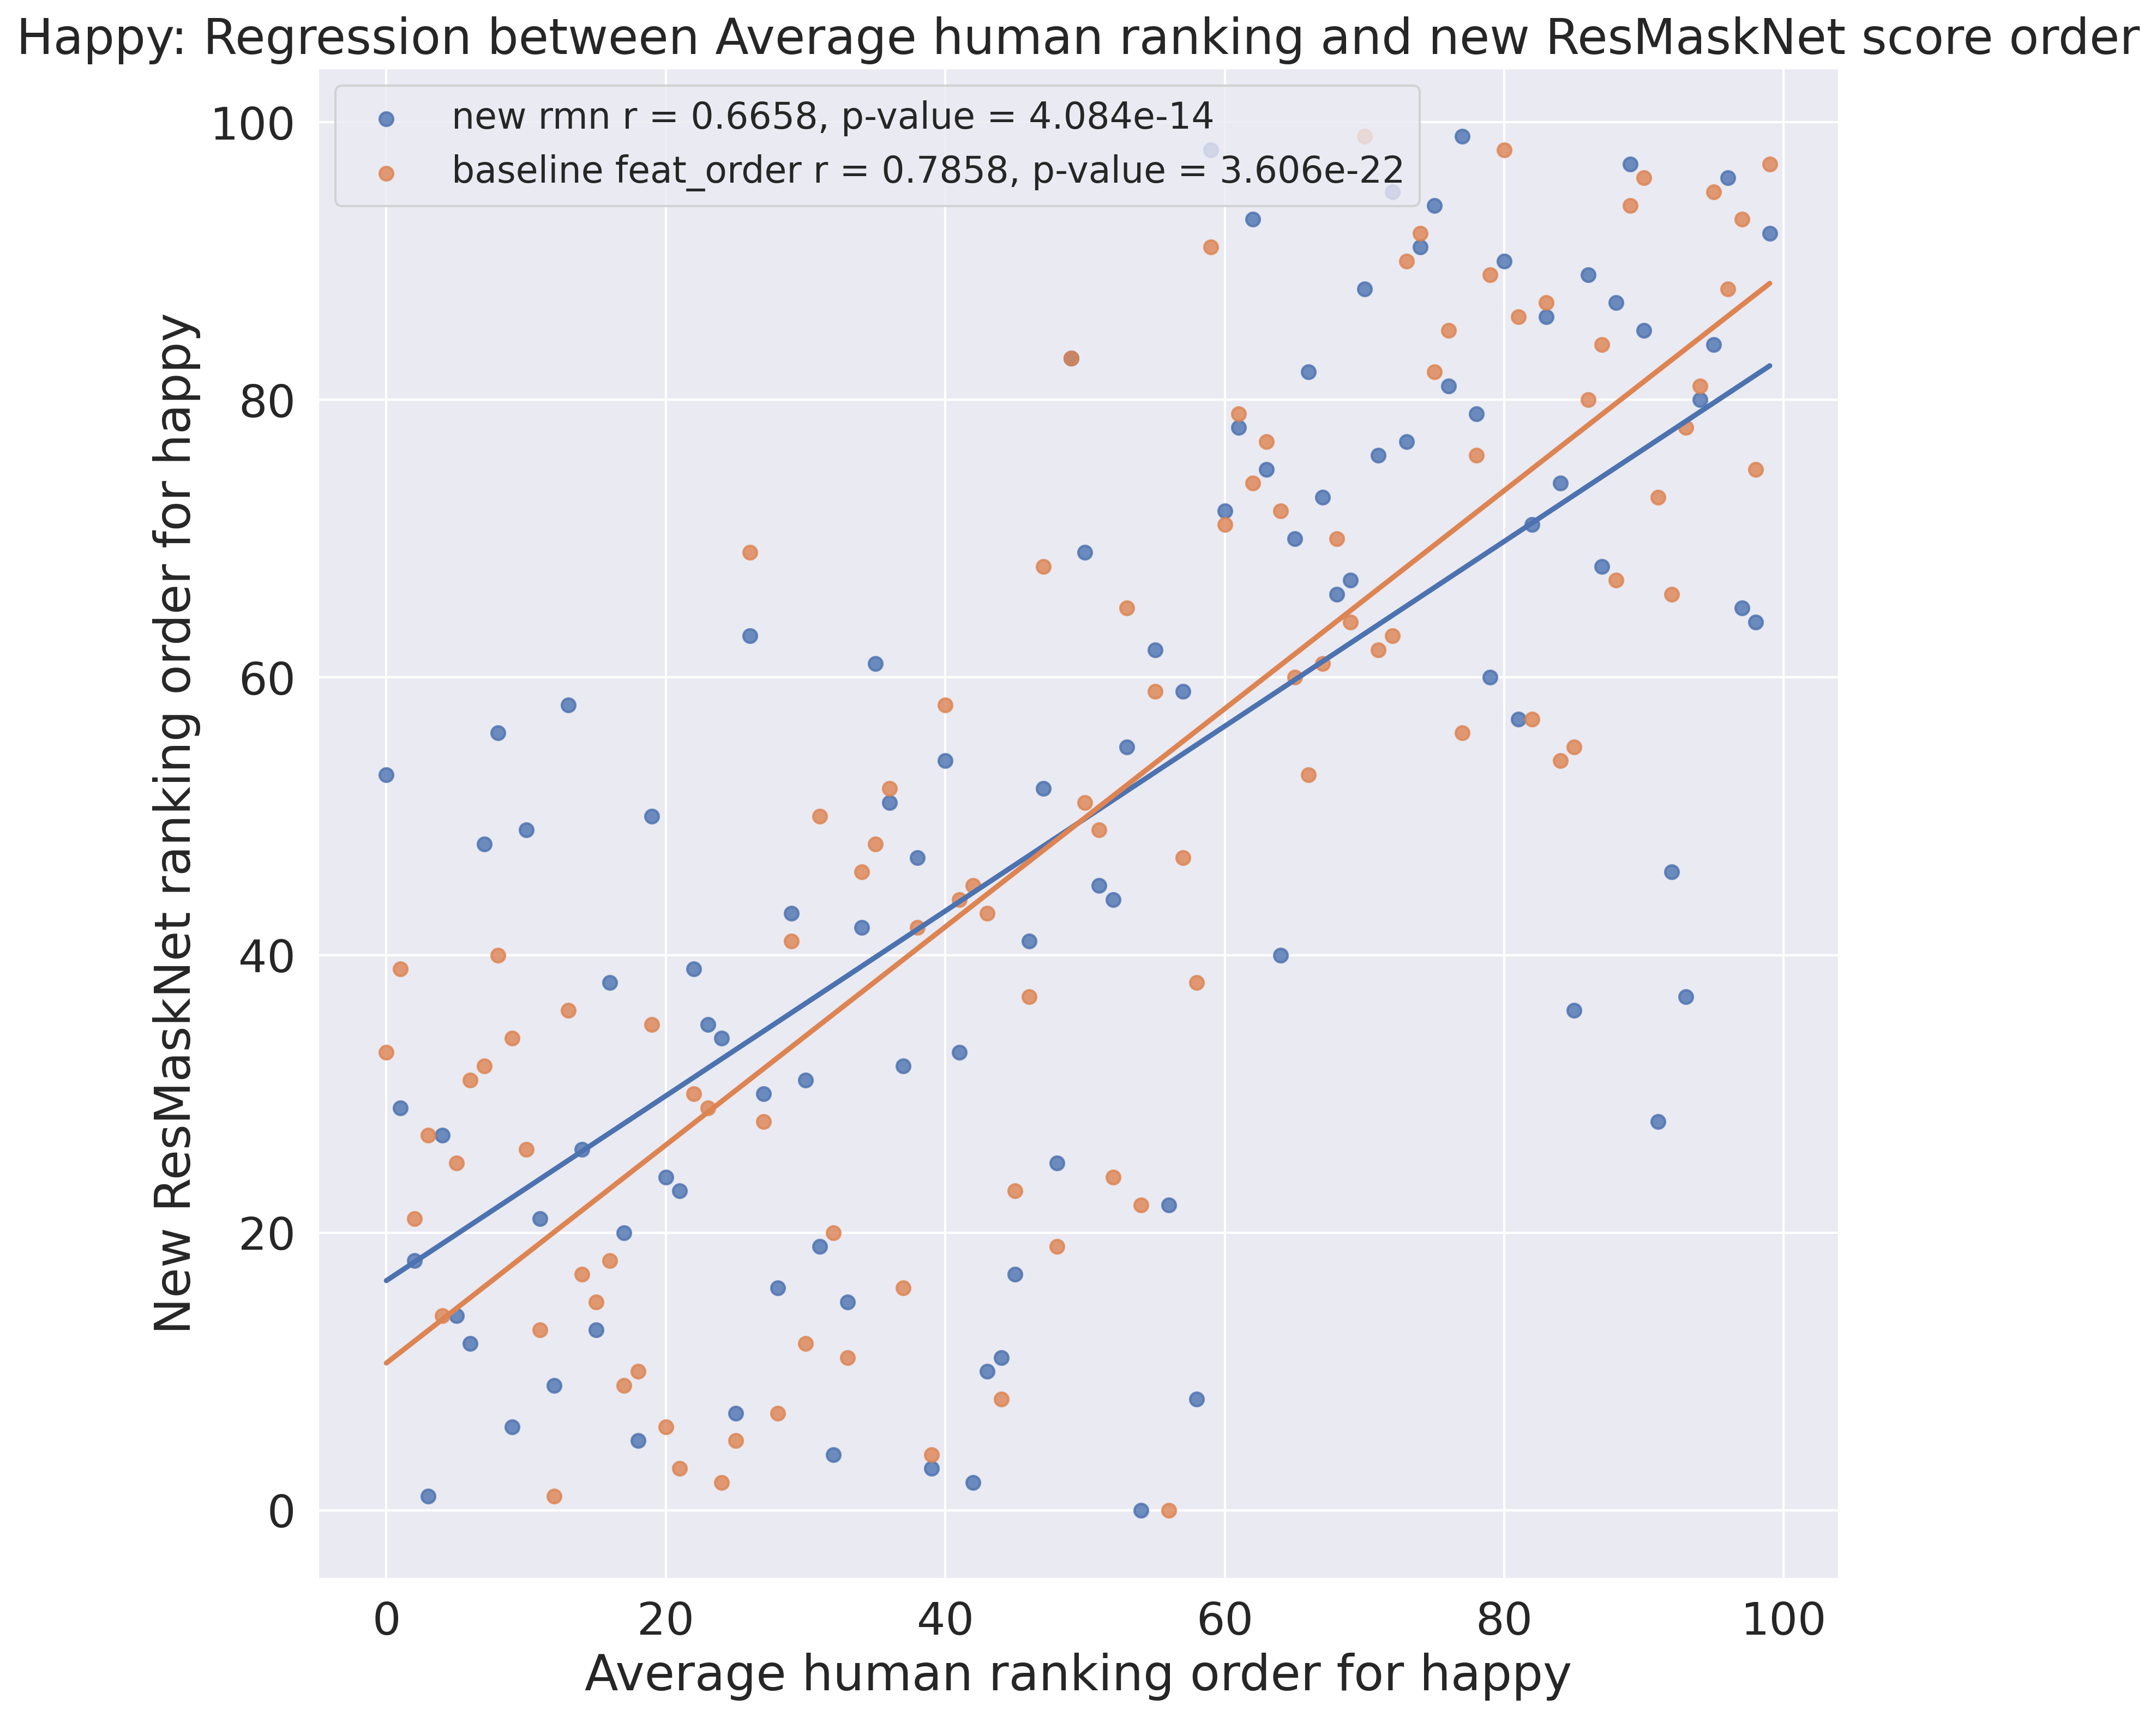

In [77]:
# Regression plot
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import copy
# print(total_data.head())

# myexp = 'angry'
# total data is raw_data 
# total pyfeat data is feat_order

values = []

final_rank = final_rank
# [new RMN order, [average human rating order, new RMN score]]
myexp = 'happy'
sns.set(font_scale = 1.8)

f, ax = plt.subplots(figsize=(12, 12), dpi=300)
f.set_facecolor('white') # set background color
ax.set_title('{}: Regression between Average human ranking and new ResMaskNet score order'.format(myexp.title())) # title
ax.set_xlabel('Average human ranking order for {}'.format(myexp)) # x-axis
ax.set_ylabel('New ResMaskNet ranking order for {}'.format(myexp)) # y-axis


x = [k[1][0] for k in final_rank] # average human ranking order
y1 = [m[0] for m in final_rank] # new ResMaskNet ranking order
y2 = old_feat_order
yy = [y1, y2]

s_name = ['new rmn', 'baseline feat_order']
for i, y in enumerate(yy):
    X, y = np.array(x), np.array(y)
    # print(X, y)
    X = X[:, None] # Reshape to 2D as requested
    reg = LinearRegression()
    reg.fit(X, y)

    # Predict response
    predictions = reg.predict(X)

    # Use stats linregress library
    reg2 = stats.linregress(x, y)
    
    # r is The Pearson correlation coefficient
    sns.regplot(x=x, y=y, ci=None, label=s_name[i] + ' r = {:.4}, p-value = {:.4}'.format(reg2.rvalue, reg2.pvalue)) # type: ignore
    # sns.regplot(x=x, y=y, ci=None, label=s_name) # type: ignore
    plt.legend(loc='upper left', fontsize=16)
    # break
    # save fig when needed
    # plt.savefig('{}_linear_regression_fitting.png'.format(myexp), bbox_inches='tight', dpi=300)
# analysis_path = 'curves'
# plt.savefig(os.path.join(analysis_path, f'{myexp}_regression_fitting_aver_human_and_new_rmn.png'), bbox_inches='tight', dpi=300)

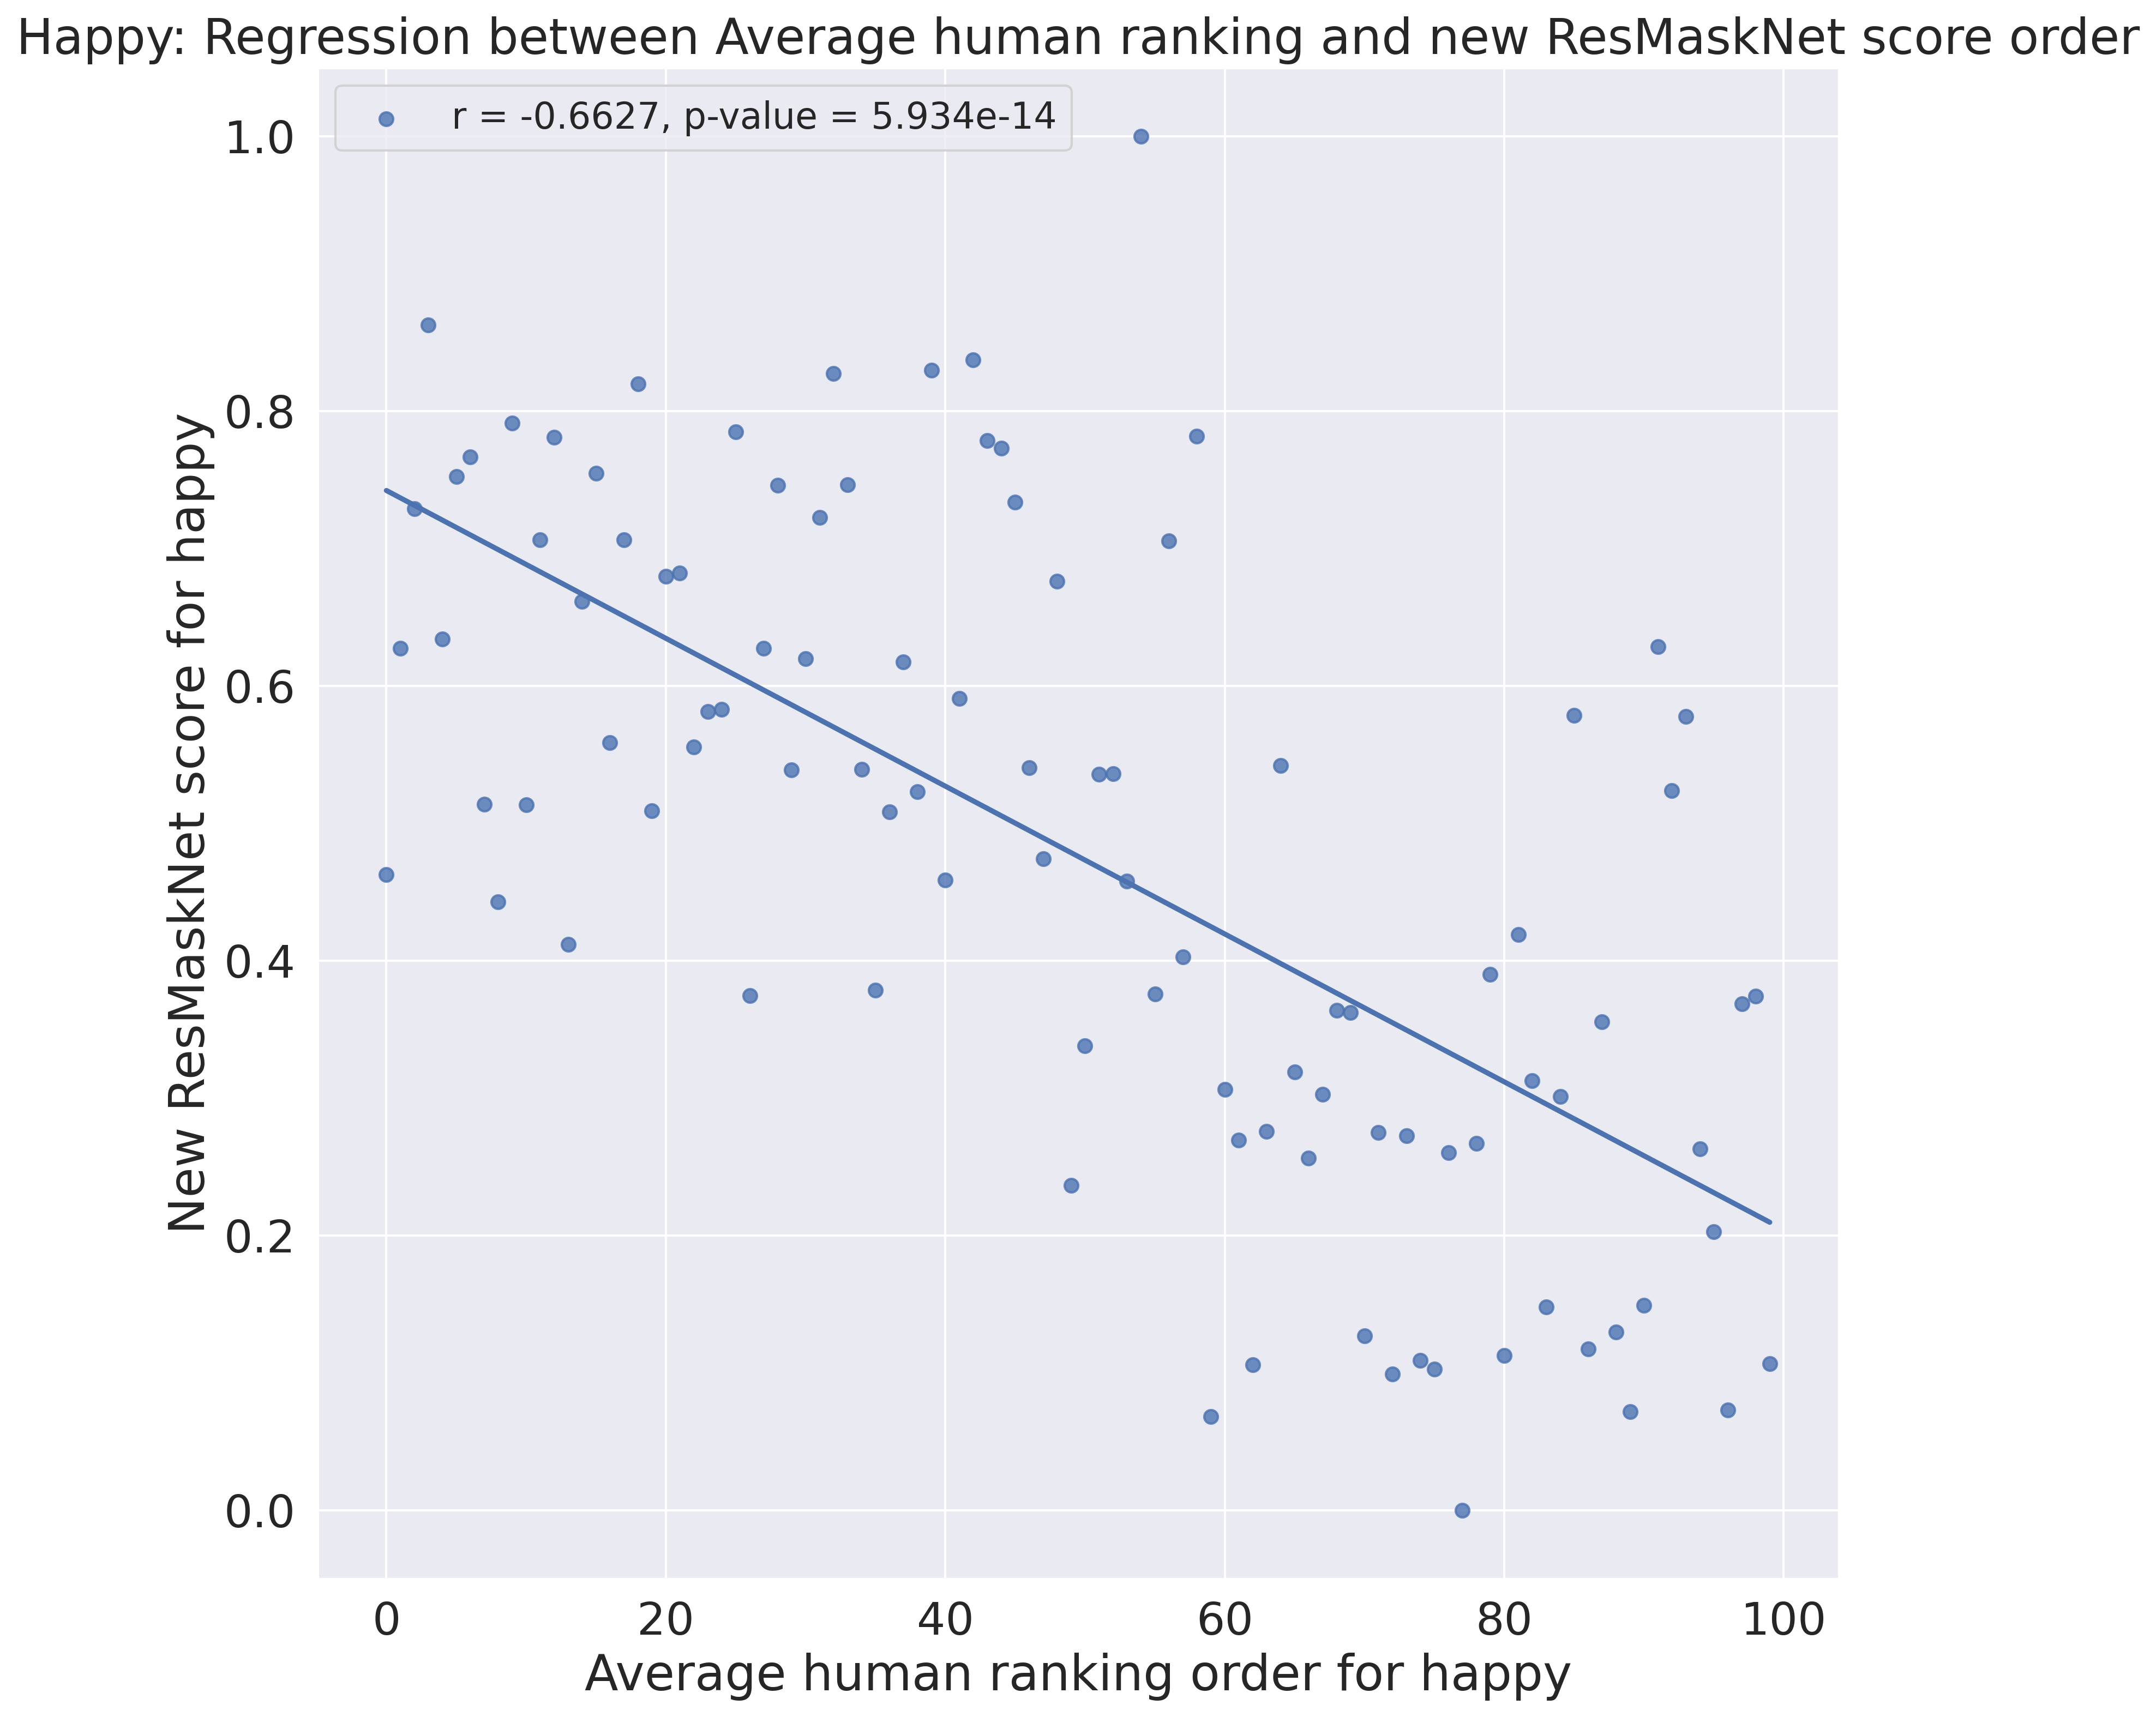

In [76]:
# use score
# Regression plot
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import copy
# print(total_data.head())

# myexp = 'angry'
# total data is raw_data 
# total pyfeat data is feat_order

values = []

final_rank = final_rank
# [new RMN order, [average human rating order, new RMN score]]
myexp = 'happy'
sns.set(font_scale = 1.8)

f, ax = plt.subplots(figsize=(12, 12), dpi=300)
f.set_facecolor('white') # set background color
ax.set_title('{}: Regression between Average human ranking and new ResMaskNet score order'.format(myexp.title())) # title
ax.set_xlabel('Average human ranking order for {}'.format(myexp)) # x-axis
ax.set_ylabel('New ResMaskNet score for {}'.format(myexp)) # y-axis



y = [k[1][1] for k in final_rank] # new ResMaskNet score
x = [m[1][0] for m in final_rank] # average human ranking order

X, y = np.array(x), np.array(y)
# print(X, y)
X = X[:, None] # Reshape to 2D as requested
reg = LinearRegression()
reg.fit(X, y)

# Predict response
predictions = reg.predict(X)

# Use stats linregress library
reg2 = stats.linregress(x, y)

s_name = ['aver', 'new rmn']
# r is The Pearson correlation coefficient

sns.regplot(x=x, y=y, ci=None, label='r = {:.4}, p-value = {:.4}'.format(reg2.rvalue, reg2.pvalue)) # type: ignore
# sns.regplot(x=x, y=y, ci=None, label=s_name) # type: ignore
plt.legend(loc='upper left', fontsize=16)

# save fig when needed
# plt.savefig('{}_linear_regression_fitting.png'.format(myexp), bbox_inches='tight', dpi=300)

analysis_path = 'curves'
# plt.savefig(os.path.join(analysis_path, f'{myexp}_regression_fitting_aver_human_and_new_rmn_value.png'), bbox_inches='tight', dpi=300)